In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [17]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

torch.manual_seed(19)

In [18]:


class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # print(np.max(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)),image.T.shape, )
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        return torch.tensor(image), torch.tensor(label_temp)

In [19]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train_EST")
test_data = NCarsImageDataset("./Datasety/test_EST")



In [20]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [21]:
from torch import nn

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2__128x128_pretrained.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [23]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [24]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kern

In [25]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

### Copy of a weights

In [27]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Con

In [28]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [29]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

In [30]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

  0%|          | 0/482 [00:00<?, ?it/s]

100%|██████████| 482/482 [00:56<00:00,  8.55it/s]


Epoch [1/120], Step [482/482], Loss: 0.6964, Accuracy: 0.4855
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:54<00:00,  8.78it/s]


Epoch [2/120], Step [482/482], Loss: 0.6961, Accuracy: 0.4868
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.74it/s]


Epoch [3/120], Step [482/482], Loss: 0.6941, Accuracy: 0.4851
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.70it/s]


Epoch [4/120], Step [482/482], Loss: 0.6949, Accuracy: 0.4844
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:56<00:00,  8.60it/s]


Epoch [5/120], Step [482/482], Loss: 0.6991, Accuracy: 0.4900
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:56<00:00,  8.60it/s]


Epoch [6/120], Step [482/482], Loss: 0.6961, Accuracy: 0.4877
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:56<00:00,  8.57it/s]


Epoch [7/120], Step [482/482], Loss: 0.6949, Accuracy: 0.4870
Accuracy of the network: 48.925293365864995 Loss: 0.6920567185905343%


100%|██████████| 482/482 [00:56<00:00,  8.58it/s]


Epoch [8/120], Step [482/482], Loss: 0.6946, Accuracy: 0.4868
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.75it/s]


Epoch [9/120], Step [482/482], Loss: 0.6948, Accuracy: 0.4864
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  8.96it/s]


Epoch [10/120], Step [482/482], Loss: 0.6956, Accuracy: 0.4836
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  8.99it/s]


Epoch [11/120], Step [482/482], Loss: 0.6947, Accuracy: 0.4883
Accuracy of the network: 48.762635064482396 Loss: 0.6931575011586611%


100%|██████████| 482/482 [00:53<00:00,  8.95it/s]


Epoch [12/120], Step [482/482], Loss: 0.6961, Accuracy: 0.4872
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:55<00:00,  8.73it/s]


Epoch [13/120], Step [482/482], Loss: 0.6957, Accuracy: 0.4916
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  9.02it/s]


Epoch [14/120], Step [482/482], Loss: 0.6923, Accuracy: 0.4887
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  9.02it/s]


Epoch [15/120], Step [482/482], Loss: 0.6940, Accuracy: 0.4857
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:54<00:00,  8.80it/s]


Epoch [16/120], Step [482/482], Loss: 0.6935, Accuracy: 0.4896
Accuracy of the network: 48.925293365864995 Loss: 0.693147182243021%


100%|██████████| 482/482 [00:53<00:00,  9.08it/s]


Epoch [17/120], Step [482/482], Loss: 0.6888, Accuracy: 0.4868
Accuracy of the network: 48.925293365864995 Loss: 0.698135092355948%


100%|██████████| 482/482 [00:53<00:00,  9.05it/s]


Epoch [18/120], Step [482/482], Loss: 0.6607, Accuracy: 0.5484
Accuracy of the network: 48.925293365864995 Loss: 0.6917668339488231%


100%|██████████| 482/482 [00:52<00:00,  9.14it/s]


Epoch [19/120], Step [482/482], Loss: 0.5648, Accuracy: 0.6929
Accuracy of the network: 72.40618101545253 Loss: 0.5854943308245294%


100%|██████████| 482/482 [00:50<00:00,  9.52it/s]


Epoch [20/120], Step [482/482], Loss: 0.4405, Accuracy: 0.8101
Accuracy of the network: 75.24108283954921 Loss: 0.5225559165043459%


100%|██████████| 482/482 [00:50<00:00,  9.50it/s]


Epoch [21/120], Step [482/482], Loss: 0.3802, Accuracy: 0.8480
Accuracy of the network: 78.33159056581852 Loss: 0.4772329611849164%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [22/120], Step [482/482], Loss: 0.3569, Accuracy: 0.8603
Accuracy of the network: 78.68014406878123 Loss: 0.4789831996185629%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [23/120], Step [482/482], Loss: 0.3467, Accuracy: 0.8674
Accuracy of the network: 78.99384222144766 Loss: 0.47112907214457217%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [24/120], Step [482/482], Loss: 0.3420, Accuracy: 0.8699
Accuracy of the network: 77.40211455791797 Loss: 0.513504145313816%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [25/120], Step [482/482], Loss: 0.3458, Accuracy: 0.8681
Accuracy of the network: 81.44533519228536 Loss: 0.4312237072943755%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [26/120], Step [482/482], Loss: 0.3315, Accuracy: 0.8768
Accuracy of the network: 82.20053444870454 Loss: 0.4226845715014908%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [27/120], Step [482/482], Loss: 0.3298, Accuracy: 0.8766
Accuracy of the network: 80.09759498082956 Loss: 0.4575290646140903%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [28/120], Step [482/482], Loss: 0.3283, Accuracy: 0.8776
Accuracy of the network: 82.00302079702567 Loss: 0.4248882833466654%


100%|██████████| 482/482 [00:50<00:00,  9.52it/s]


Epoch [29/120], Step [482/482], Loss: 0.3262, Accuracy: 0.8824
Accuracy of the network: 80.44614848379226 Loss: 0.450098393630361%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [30/120], Step [482/482], Loss: 0.3197, Accuracy: 0.8838
Accuracy of the network: 83.16486580690136 Loss: 0.4038710754267788%


100%|██████████| 482/482 [00:50<00:00,  9.54it/s]


Epoch [31/120], Step [482/482], Loss: 0.3145, Accuracy: 0.8880
Accuracy of the network: 79.00546067154642 Loss: 0.48201647423013877%


100%|██████████| 482/482 [00:50<00:00,  9.53it/s]


Epoch [32/120], Step [482/482], Loss: 0.3113, Accuracy: 0.8871
Accuracy of the network: 82.37481120018589 Loss: 0.4198818208448949%


100%|██████████| 482/482 [00:50<00:00,  9.54it/s]


Epoch [33/120], Step [482/482], Loss: 0.3114, Accuracy: 0.8891
Accuracy of the network: 81.38724294179157 Loss: 0.4410748663998891%


100%|██████████| 482/482 [00:50<00:00,  9.62it/s]


Epoch [34/120], Step [482/482], Loss: 0.3041, Accuracy: 0.8957
Accuracy of the network: 82.95573370512373 Loss: 0.4057507153780487%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [35/120], Step [482/482], Loss: 0.3073, Accuracy: 0.8915
Accuracy of the network: 81.57313814337168 Loss: 0.4334441789020836%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [36/120], Step [482/482], Loss: 0.3096, Accuracy: 0.8909
Accuracy of the network: 81.0270709887301 Loss: 0.44531991468486287%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [37/120], Step [482/482], Loss: 0.3059, Accuracy: 0.8917
Accuracy of the network: 81.34076914139654 Loss: 0.43024032194596684%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [38/120], Step [482/482], Loss: 0.2990, Accuracy: 0.8979
Accuracy of the network: 80.74822818635994 Loss: 0.44922733417674066%


100%|██████████| 482/482 [00:48<00:00,  9.96it/s]


Epoch [39/120], Step [482/482], Loss: 0.2931, Accuracy: 0.9012
Accuracy of the network: 84.09434181480191 Loss: 0.39622295550918935%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [40/120], Step [482/482], Loss: 0.2940, Accuracy: 0.9011
Accuracy of the network: 82.00302079702567 Loss: 0.4222978601668404%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [41/120], Step [482/482], Loss: 0.2873, Accuracy: 0.9049
Accuracy of the network: 82.61879865225978 Loss: 0.40776010854758293%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [42/120], Step [482/482], Loss: 0.2806, Accuracy: 0.9094
Accuracy of the network: 83.59474846055537 Loss: 0.3983540472931135%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [43/120], Step [482/482], Loss: 0.2808, Accuracy: 0.9095
Accuracy of the network: 83.49018240966655 Loss: 0.4036133270502977%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [44/120], Step [482/482], Loss: 0.2769, Accuracy: 0.9097
Accuracy of the network: 83.88520971302428 Loss: 0.39890754311501314%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [45/120], Step [482/482], Loss: 0.2751, Accuracy: 0.9122
Accuracy of the network: 83.16486580690136 Loss: 0.40075329993072495%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [46/120], Step [482/482], Loss: 0.2681, Accuracy: 0.9157
Accuracy of the network: 83.9084466132218 Loss: 0.39837601708878373%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [47/120], Step [482/482], Loss: 0.2705, Accuracy: 0.9144
Accuracy of the network: 83.79226211223423 Loss: 0.3924447625432316%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [48/120], Step [482/482], Loss: 0.2668, Accuracy: 0.9169
Accuracy of the network: 84.09434181480191 Loss: 0.3895484451689242%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [49/120], Step [482/482], Loss: 0.2580, Accuracy: 0.9208
Accuracy of the network: 84.48936911815964 Loss: 0.3764320996392615%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [50/120], Step [482/482], Loss: 0.2593, Accuracy: 0.9215
Accuracy of the network: 85.31427907517137 Loss: 0.3643935488391543%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [51/120], Step [482/482], Loss: 0.2449, Accuracy: 0.9306
Accuracy of the network: 86.9989543394911 Loss: 0.3439576261881116%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [52/120], Step [482/482], Loss: 0.2474, Accuracy: 0.9289
Accuracy of the network: 84.02463111420937 Loss: 0.39082868347380684%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [53/120], Step [482/482], Loss: 0.2462, Accuracy: 0.9296
Accuracy of the network: 86.18566283257813 Loss: 0.354964047725759%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [54/120], Step [482/482], Loss: 0.2458, Accuracy: 0.9304
Accuracy of the network: 86.04624143139306 Loss: 0.3589775796605752%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [55/120], Step [482/482], Loss: 0.2351, Accuracy: 0.9359
Accuracy of the network: 85.9765307308005 Loss: 0.3558759456673519%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [56/120], Step [482/482], Loss: 0.2349, Accuracy: 0.9360
Accuracy of the network: 85.90682003020797 Loss: 0.3570856170583392%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [57/120], Step [482/482], Loss: 0.2297, Accuracy: 0.9394
Accuracy of the network: 86.59230858603462 Loss: 0.34591777384502737%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [58/120], Step [482/482], Loss: 0.2271, Accuracy: 0.9410
Accuracy of the network: 86.08109678168933 Loss: 0.35431017275193366%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [59/120], Step [482/482], Loss: 0.2248, Accuracy: 0.9425
Accuracy of the network: 87.33588939235506 Loss: 0.3373396835916547%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [60/120], Step [482/482], Loss: 0.2193, Accuracy: 0.9458
Accuracy of the network: 86.56907168583712 Loss: 0.34994528672509034%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [61/120], Step [482/482], Loss: 0.2214, Accuracy: 0.9448
Accuracy of the network: 87.41721854304636 Loss: 0.33064875422135603%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [62/120], Step [482/482], Loss: 0.2169, Accuracy: 0.9468
Accuracy of the network: 87.21970489136748 Loss: 0.33753574609091735%


100%|██████████| 482/482 [00:48<00:00,  9.97it/s]


Epoch [63/120], Step [482/482], Loss: 0.2144, Accuracy: 0.9483
Accuracy of the network: 87.76577204600906 Loss: 0.3291569513902345%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [64/120], Step [482/482], Loss: 0.2093, Accuracy: 0.9531
Accuracy of the network: 86.7898222377135 Loss: 0.3475535591184871%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [65/120], Step [482/482], Loss: 0.2110, Accuracy: 0.9508
Accuracy of the network: 84.52422446845591 Loss: 0.3767190059875467%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [66/120], Step [482/482], Loss: 0.2073, Accuracy: 0.9530
Accuracy of the network: 86.67363773672592 Loss: 0.34896765128608975%


100%|██████████| 482/482 [00:48<00:00,  9.96it/s]


Epoch [67/120], Step [482/482], Loss: 0.2011, Accuracy: 0.9578
Accuracy of the network: 87.74253514581154 Loss: 0.33210586199751574%


100%|██████████| 482/482 [00:48<00:00,  9.98it/s]


Epoch [68/120], Step [482/482], Loss: 0.2012, Accuracy: 0.9571
Accuracy of the network: 86.58069013593587 Loss: 0.35287800575277617%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [69/120], Step [482/482], Loss: 0.1988, Accuracy: 0.9594
Accuracy of the network: 88.18403624956431 Loss: 0.3211450037238323%


100%|██████████| 482/482 [00:50<00:00,  9.57it/s]


Epoch [70/120], Step [482/482], Loss: 0.1929, Accuracy: 0.9612
Accuracy of the network: 88.6139189032183 Loss: 0.31611595765365547%


100%|██████████| 482/482 [00:50<00:00,  9.51it/s]


Epoch [71/120], Step [482/482], Loss: 0.1930, Accuracy: 0.9624
Accuracy of the network: 88.9392355059835 Loss: 0.31121059421269864%


100%|██████████| 482/482 [00:50<00:00,  9.49it/s]


Epoch [72/120], Step [482/482], Loss: 0.1919, Accuracy: 0.9638
Accuracy of the network: 87.34750784245382 Loss: 0.3377663249973914%


100%|██████████| 482/482 [00:50<00:00,  9.49it/s]


Epoch [73/120], Step [482/482], Loss: 0.1914, Accuracy: 0.9631
Accuracy of the network: 88.79981410479841 Loss: 0.3132972530051235%


100%|██████████| 482/482 [00:50<00:00,  9.55it/s]


Epoch [74/120], Step [482/482], Loss: 0.1869, Accuracy: 0.9646
Accuracy of the network: 88.70686650400836 Loss: 0.31540027820266314%


100%|██████████| 482/482 [00:50<00:00,  9.54it/s]


Epoch [75/120], Step [482/482], Loss: 0.1864, Accuracy: 0.9671
Accuracy of the network: 89.83385616358778 Loss: 0.2950873099627548%


100%|██████████| 482/482 [00:50<00:00,  9.57it/s]


Epoch [76/120], Step [482/482], Loss: 0.1852, Accuracy: 0.9671
Accuracy of the network: 89.13674915766236 Loss: 0.30868543651245783%


100%|██████████| 482/482 [00:50<00:00,  9.57it/s]


Epoch [77/120], Step [482/482], Loss: 0.1821, Accuracy: 0.9688
Accuracy of the network: 88.21889159986058 Loss: 0.32032339031146806%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [78/120], Step [482/482], Loss: 0.1801, Accuracy: 0.9698
Accuracy of the network: 88.96247240618102 Loss: 0.3134417315065639%


100%|██████████| 482/482 [00:50<00:00,  9.58it/s]


Epoch [79/120], Step [482/482], Loss: 0.1781, Accuracy: 0.9709
Accuracy of the network: 90.14755431625422 Loss: 0.2918589612032844%


100%|██████████| 482/482 [00:50<00:00,  9.55it/s]


Epoch [80/120], Step [482/482], Loss: 0.1747, Accuracy: 0.9741
Accuracy of the network: 88.64877425351457 Loss: 0.3132211398125581%


100%|██████████| 482/482 [00:50<00:00,  9.57it/s]


Epoch [81/120], Step [482/482], Loss: 0.1753, Accuracy: 0.9720
Accuracy of the network: 88.76495875450215 Loss: 0.3124004570303353%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [82/120], Step [482/482], Loss: 0.1745, Accuracy: 0.9732
Accuracy of the network: 89.81061926339027 Loss: 0.29872993454614094%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [83/120], Step [482/482], Loss: 0.1697, Accuracy: 0.9767
Accuracy of the network: 88.95085395608226 Loss: 0.31128160156946644%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [84/120], Step [482/482], Loss: 0.1710, Accuracy: 0.9754
Accuracy of the network: 89.25293365864994 Loss: 0.3042431629944911%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [85/120], Step [482/482], Loss: 0.1698, Accuracy: 0.9756
Accuracy of the network: 88.52097130242825 Loss: 0.31767053204176593%


100%|██████████| 482/482 [00:50<00:00,  9.56it/s]


Epoch [86/120], Step [482/482], Loss: 0.1688, Accuracy: 0.9775
Accuracy of the network: 89.86871151388405 Loss: 0.2936305470182993%


100%|██████████| 482/482 [00:50<00:00,  9.57it/s]


Epoch [87/120], Step [482/482], Loss: 0.1665, Accuracy: 0.9783
Accuracy of the network: 89.92680376437784 Loss: 0.2937270327017653%


100%|██████████| 482/482 [00:49<00:00,  9.76it/s]


Epoch [88/120], Step [482/482], Loss: 0.1662, Accuracy: 0.9789
Accuracy of the network: 90.33344951783432 Loss: 0.28855944915110293%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [89/120], Step [482/482], Loss: 0.1638, Accuracy: 0.9802
Accuracy of the network: 89.33426280934124 Loss: 0.306911376273765%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [90/120], Step [482/482], Loss: 0.1613, Accuracy: 0.9805
Accuracy of the network: 89.2064598582549 Loss: 0.30344609074211476%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [91/120], Step [482/482], Loss: 0.1625, Accuracy: 0.9809
Accuracy of the network: 89.81061926339027 Loss: 0.29679265867600213%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [92/120], Step [482/482], Loss: 0.1617, Accuracy: 0.9818
Accuracy of the network: 90.74009527129081 Loss: 0.28285243569918284%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [93/120], Step [482/482], Loss: 0.1599, Accuracy: 0.9824
Accuracy of the network: 89.55501336121762 Loss: 0.2999985835144511%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [94/120], Step [482/482], Loss: 0.1580, Accuracy: 0.9836
Accuracy of the network: 89.78738236319275 Loss: 0.29665089268445083%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [95/120], Step [482/482], Loss: 0.1580, Accuracy: 0.9833
Accuracy of the network: 89.84547461368653 Loss: 0.29610415589632155%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [96/120], Step [482/482], Loss: 0.1567, Accuracy: 0.9850
Accuracy of the network: 90.13593586615545 Loss: 0.2928827609936101%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [97/120], Step [482/482], Loss: 0.1605, Accuracy: 0.9813
Accuracy of the network: 90.43801556872313 Loss: 0.28774516123821303%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [98/120], Step [482/482], Loss: 0.1563, Accuracy: 0.9844
Accuracy of the network: 90.41477866852561 Loss: 0.2882126996840686%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [99/120], Step [482/482], Loss: 0.1545, Accuracy: 0.9859
Accuracy of the network: 88.76495875450215 Loss: 0.3126336672935344%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [100/120], Step [482/482], Loss: 0.1553, Accuracy: 0.9846
Accuracy of the network: 90.33344951783432 Loss: 0.2895491628952629%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [101/120], Step [482/482], Loss: 0.1559, Accuracy: 0.9850
Accuracy of the network: 90.42639711862438 Loss: 0.28921754968432245%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [102/120], Step [482/482], Loss: 0.1528, Accuracy: 0.9871
Accuracy of the network: 90.19402811664924 Loss: 0.292561894123439%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [103/120], Step [482/482], Loss: 0.1534, Accuracy: 0.9862
Accuracy of the network: 89.24131520855119 Loss: 0.30740113246174994%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [104/120], Step [482/482], Loss: 0.1522, Accuracy: 0.9866
Accuracy of the network: 89.8803299639828 Loss: 0.29802880688227684%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [105/120], Step [482/482], Loss: 0.1493, Accuracy: 0.9890
Accuracy of the network: 89.9616591146741 Loss: 0.2956501387862911%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [106/120], Step [482/482], Loss: 0.1498, Accuracy: 0.9883
Accuracy of the network: 90.28697571743929 Loss: 0.2891067800468672%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [107/120], Step [482/482], Loss: 0.1508, Accuracy: 0.9880
Accuracy of the network: 89.97327756477286 Loss: 0.2966072216463798%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [108/120], Step [482/482], Loss: 0.1502, Accuracy: 0.9887
Accuracy of the network: 89.6131056117114 Loss: 0.3006431787762943%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [109/120], Step [482/482], Loss: 0.1484, Accuracy: 0.9898
Accuracy of the network: 90.19402811664924 Loss: 0.2900551169778335%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [110/120], Step [482/482], Loss: 0.1477, Accuracy: 0.9898
Accuracy of the network: 90.42639711862438 Loss: 0.28890188487045826%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [111/120], Step [482/482], Loss: 0.1472, Accuracy: 0.9901
Accuracy of the network: 90.1243174160567 Loss: 0.29198642352035054%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [112/120], Step [482/482], Loss: 0.1477, Accuracy: 0.9899
Accuracy of the network: 90.46125246892065 Loss: 0.28690510052065865%


100%|██████████| 482/482 [00:48<00:00, 10.00it/s]


Epoch [113/120], Step [482/482], Loss: 0.1459, Accuracy: 0.9908
Accuracy of the network: 90.18240966655048 Loss: 0.2922654474867321%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [114/120], Step [482/482], Loss: 0.1468, Accuracy: 0.9912
Accuracy of the network: 90.05460671546416 Loss: 0.2920018828934453%


100%|██████████| 482/482 [00:48<00:00,  9.99it/s]


Epoch [115/120], Step [482/482], Loss: 0.1452, Accuracy: 0.9914
Accuracy of the network: 89.86871151388405 Loss: 0.29499488138354846%


100%|██████████| 482/482 [00:50<00:00,  9.62it/s]


Epoch [116/120], Step [482/482], Loss: 0.1462, Accuracy: 0.9909
Accuracy of the network: 90.0429882653654 Loss: 0.29486301081552824%


100%|██████████| 482/482 [00:50<00:00,  9.51it/s]


Epoch [117/120], Step [482/482], Loss: 0.1446, Accuracy: 0.9920
Accuracy of the network: 90.21726501684675 Loss: 0.292208848721919%


100%|██████████| 482/482 [00:51<00:00,  9.37it/s]


Epoch [118/120], Step [482/482], Loss: 0.1444, Accuracy: 0.9918
Accuracy of the network: 90.54258161961194 Loss: 0.29010985337447054%


100%|██████████| 482/482 [00:52<00:00,  9.20it/s]


Epoch [119/120], Step [482/482], Loss: 0.1438, Accuracy: 0.9927
Accuracy of the network: 89.93842221447659 Loss: 0.2967482526616979%


100%|██████████| 482/482 [00:51<00:00,  9.37it/s]


Epoch [120/120], Step [482/482], Loss: 0.1442, Accuracy: 0.9924
Accuracy of the network: 90.28697571743929 Loss: 0.29288114834452206%


In [35]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128_pretrained.pt")

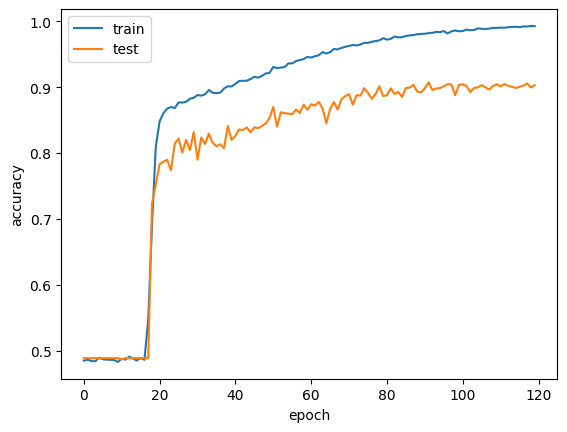

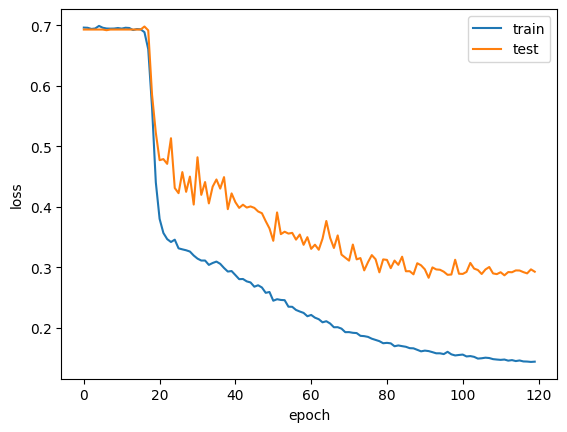

In [36]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [37]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_128x128_pretrained.csv')

In [38]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.485475,0.489253,0.696354,0.693147
1,0.486837,0.489253,0.696056,0.693147
2,0.485086,0.489253,0.694117,0.693147
3,0.484438,0.489253,0.694900,0.693147
4,0.490014,0.489253,0.699120,0.693147
